In [39]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [1]:
!nvidia-smi


Mon Dec  2 09:25:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8             14W /   40W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [2]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available and ready to use!")
    print("Details:", tf.config.list_physical_devices('GPU'))
else:
    print("GPU not available. Using CPU instead.")


GPU not available. Using CPU instead.


In [16]:
IMAGE_SIZE = 128 
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_data = tf.random.uniform((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [17]:
training_set = tf.keras.utils.image_dataset_from_directory(
    '../Data/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


In [18]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    '../Data/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


In [8]:
classnames = training_set.class_names
classnames

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [9]:
# plt.figure(figsize=(15, 30))  # Set figure size for better visibility (wider and taller)

# for image_batch, label_batch in training_set.take(1):  # Take one batch of data
#     batch_size = image_batch.shape[0]  # Actual number of images in the batch
#     num_images_to_show = min(15, batch_size)  # Adjust the number of images to visualize
#     for i in range(num_images_to_show):  # Display only the selected number of images
#         plt.subplot((num_images_to_show // 3) + 1, 3, i + 1)  # Create a 3-column layout
#         plt.imshow(image_batch[i].numpy().astype('uint8'))  # Display image
#         plt.title(classnames[label_batch[i].numpy()])  # Get class name from index
#         plt.axis('off')  # Turn off axes

# plt.tight_layout()
# plt.show()

In [10]:
# caching
train_dataset = training_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



In [11]:
# generally the image numbers are between 255 and 1 so now we must scale it between 0 and 1 
resize_and_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255)
])

In [12]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])
data_augmentation


<Sequential name=sequential_1, built=False>

In [33]:
model_cnn = tf.keras.models.Sequential()
# cnn.add(resize_and_rescale),
model_cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
model_cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
model_cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model_cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
model_cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model_cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
model_cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model_cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
model_cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model_cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
model_cnn.add(tf.keras.layers.Dropout(0.25))
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting
#Output Layer
model_cnn.add(tf.keras.layers.Dense(units=38,activation='softmax'))

D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [35]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1500)                │       3,073,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │          57,038 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,842,762 (29.92 MB)

 Trainable params: 7,842,762 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
training_history = model_cnn.fit(x=training_set,validation_data=validation_set,epochs=5)

Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 983s 446ms/step - accuracy: 0.4121 - loss: 2.0728 - val_accuracy: 0.8458 - val_loss: 0.4887
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 929s 423ms/step - accuracy: 0.8396 - loss: 0.5141 - val_accuracy: 0.9039 - val_loss: 0.3016
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 907s 413ms/step - accuracy: 0.9048 - loss: 0.2921 - val_accuracy: 0.9411 - val_loss: 0.1794
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 879s 400ms/step - accuracy: 0.9386 - loss: 0.1919 - val_accuracy: 0.9389 - val_loss: 0.1913
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 865s 394ms/step - accuracy: 0.9531 - loss: 0.1422 - val_accuracy: 0.9553 - val_loss: 0.1461


In [ ]:
folder_path = 'tract_models'
os.makedirs(folder_path, exist_ok=True)

In [43]:
model_name = 'my_model_epoch_10.keras'
model.save(os.path.join(folder_path, model_name))

In [19]:
cnn.save('trained_plant_disease_model.keras')

In [20]:
cnn.save('trained_plant_disease_model.h5')

In [30]:
model = load_model("trained_plant_disease_model.keras")
model

<Sequential name=sequential_2, built=True>

In [20]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 289s 131ms/step - accuracy: 0.9625 - loss: 0.1118
Training accuracy: 0.9619603157043457


In [23]:
val_loss, val_acc = model.evaluate(validation_set)
print(f"The Validation accuracy is :{val_acc}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 71s 129ms/step - accuracy: 0.9364 - loss: 0.1976
The Validation accuracy is :0.9348964095115662


In [44]:
training_history.history

{'accuracy': [0.6086065769195557,
  0.8624653220176697,
  0.914560079574585,
  0.9424710273742676,
  0.9547194242477417],
 'loss': [1.324412226676941,
  0.43680480122566223,
  0.2603900134563446,
  0.17783363163471222,
  0.1364046335220337],
 'val_accuracy': [0.8457773923873901,
  0.9038811922073364,
  0.9410994648933411,
  0.9389369487762451,
  0.9552697539329529],
 'val_loss': [0.4886595606803894,
  0.3016372621059418,
  0.17943717539310455,
  0.19131560623645782,
  0.14614449441432953]}

In [47]:
# # COnverting the history to a json file 
# import json 
# with open('training_history.json','w') as f:
#     json.dump(training_history.history,f)

In [50]:
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Access the content
print(history)

{'accuracy': [0.6086065769195557, 0.8624653220176697, 0.914560079574585, 0.9424710273742676, 0.9547194242477417], 'loss': [1.324412226676941, 0.43680480122566223, 0.2603900134563446, 0.17783363163471222, 0.1364046335220337], 'val_accuracy': [0.8457773923873901, 0.9038811922073364, 0.9410994648933411, 0.9389369487762451, 0.9552697539329529], 'val_loss': [0.4886595606803894, 0.3016372621059418, 0.17943717539310455, 0.19131560623645782, 0.14614449441432953]}


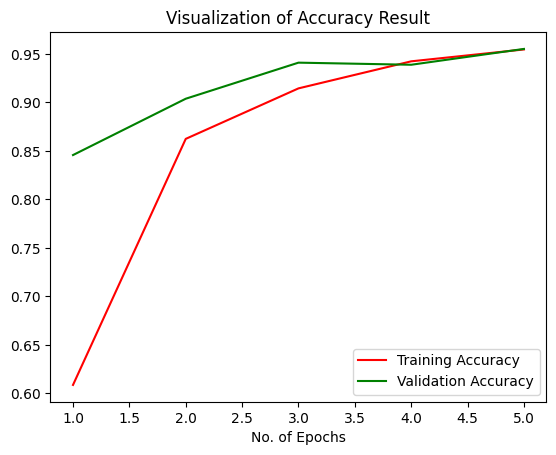

In [51]:
epochs = [i for i in range(1,6)]

plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='green',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

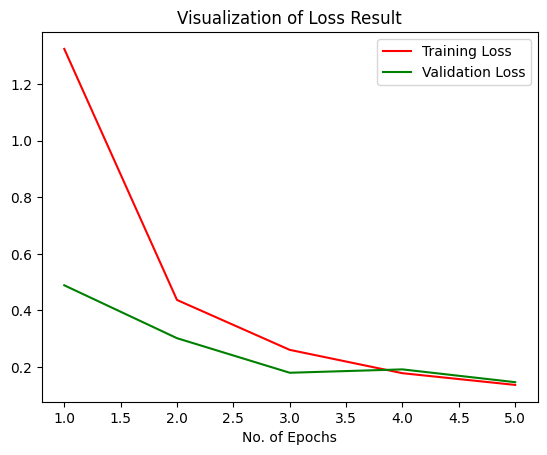

In [52]:
epochs = [i for i in range(1,6)]

plt.plot(epochs,training_history.history['loss'],color='red',label='Training Loss')
plt.plot(epochs,training_history.history['val_loss'],color='green',label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()